![title](Image/power.jpg)

## 전력 생산량 데이터

#### 선형회귀분석(Linear Regression)을 이용한 전력 데이터 분석
[데이터 다운로드](http://data.go.kr/dataset/3068304/fileData.do)<br>
[소스 출처](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

### 연도별 전력 생산량 데이터

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
# 데이터 읽어오기
data = pd.read_excel('data/GeneratedEnergy.xlsx')
data.head(5)

,year,water power,steam power,fire power,internal-combustion power,nuclear power,group,substitution,buy,total
0,2000,5609822,119947533,26863140,293861,108963740,0,0,4721413,266399508
1,2001,4150753,135436741,29032971,324939,112133033,0,0,4145321,285223757
2,2002,5311047,138929484,38336951,353023,119102905,0,0,4440656,306474064
3,2003,6886983,140269475,40374646,370125,129671763,0,0,4878706,322451697
4,2004,5861434,145364710,55451941,406895,130714816,3552538,350183,445453,342147967


In [3]:
# 시계열 분석에서 year column은 불필요함으로 제거한다
dataset = pd.DataFrame(data.drop('year', axis=1))

In [4]:
dataset.describe()

,water power,steam power,fire power,internal-combustion power,nuclear power,group,substitution,buy,total
count,1.600000e+01,1.600000e+01,1.600000e+01,16.000000,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01
mean,6.155056e+06,1.772373e+08,7.332181e+07,570168.875000,1.407112e+08,6.979149e+06,4.257624e+06,1.766495e+06,4.109961e+08
std,1.224840e+06,3.575108e+07,3.118344e+07,172408.381448,1.623582e+07,7.092117e+06,5.700004e+06,1.725620e+06,9.033858e+07
min,4.150753e+06,1.199475e+08,2.686314e+07,293861.000000,1.089637e+08,0.000000e+00,0.000000e+00,2.693410e+05,2.663995e+08
25%,5.287940e+06,1.440909e+08,5.168262e+07,397702.500000,1.304541e+08,1.947548e+06,2.626372e+05,5.727195e+05,3.372239e+08
50%,5.718601e+06,1.785352e+08,7.082885e+07,610760.000000,1.472749e+08,4.303480e+06,1.102124e+06,8.361295e+05,4.127398e+08
75%,7.088987e+06,2.112659e+08,1.008186e+08,705388.500000,1.504850e+08,1.254998e+07,7.848758e+06,2.606921e+06,5.000636e+08
max,8.393928e+06,2.185853e+08,1.244000e+08,820533.000000,1.647624e+08,2.201871e+07,1.731795e+07,4.878706e+06,5.280912e+08


In [5]:
features=list(dataset.columns[:]) # 속성값 가져오기
features

['water power',
 'steam power',
 'fire power',
 'internal-combustion power',
 'nuclear power',
 'group',
 'substitution',
 'buy',
 'total']

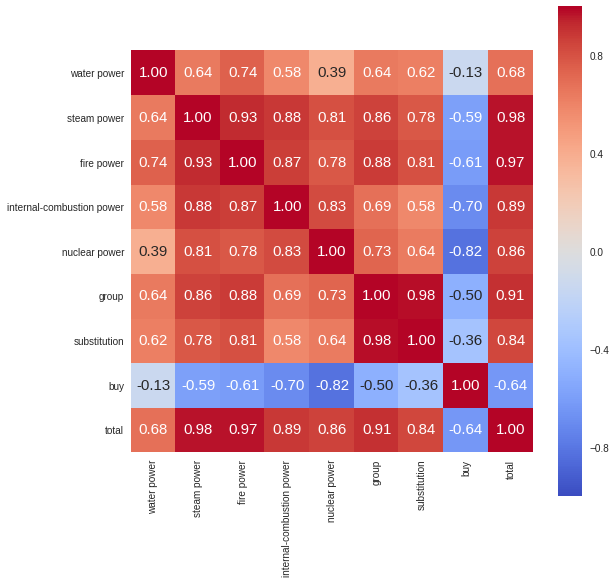

In [6]:
# 상관관계 파악을 위한 히트맵(hit map)작성
corr = dataset[features].corr()
plt.figure(figsize=(9,9))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features,
           cmap= 'coolwarm')
plt.show()

In [7]:
# 배열을 dataset matrix 형태로 바꾼다.
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [8]:
from sklearn.preprocessing import MinMaxScaler # 최대 최소 정규화
from sklearn.linear_model import LinearRegression

dataset = dataset['buy'] # 생산량 column 읽기
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

/home/ccnlml/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/ccnlml/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ccnlml/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [9]:
# 7:3 비율로 훈련데이터와 테스트 데이터 분할
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
train = np.array(train)
test = np.array(test)

In [10]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
#회귀분석
lm = LinearRegression()
lm.fit(trainX, trainY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
# make predictions
trainPredict_lm = lm.predict(trainX)
testPredict_lm = lm.predict(testX)

In [13]:
# invert predictions
trainPredict_lm = scaler.inverse_transform(trainPredict_lm.reshape(-1, 1))
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict_lm = scaler.inverse_transform(testPredict_lm.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

In [14]:
totalPredict_lm = np.append(trainPredict_lm, testPredict_lm)

In [15]:
len(dataset)

16

/home/ccnlml/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


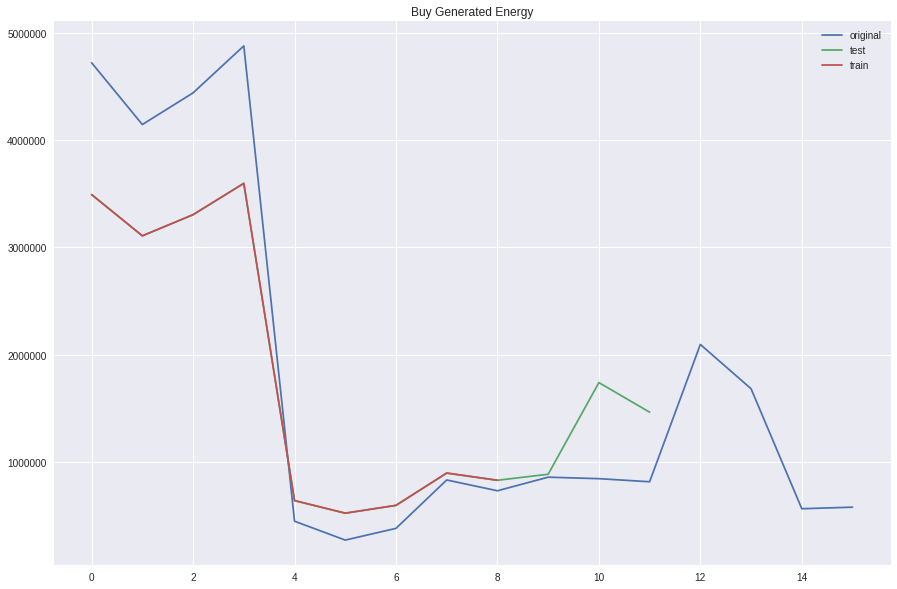

In [16]:
plt.clf()
plt.figure(figsize=(15, 10))
# plot baseline and predictions
plt.title('Buy Generated Energy')
plt.plot(scaler.inverse_transform(dataset), label='original')
plt.plot(totalPredict_lm, label='test')
plt.plot(trainPredict_lm, label='train')
plt.legend()
plt.show()

### 주별 최대 전력 생산량 데이터

[데이터 다운로드](http://data.go.kr/dataset/3069726/fileData.do)

In [17]:
# 데이터 읽어오기
mydata2 = pd.read_excel('data/weekly_max.xlsx')

In [18]:
# 시계열 분석을 위해 요일을 없애고 한개의 column으로 통일한다
mydata2 = mydata2.drop('week', axis=1)
mydata2.head(5)

,sun,mon,tue,wed,thu,fri,sat
0,65000,78800,78000,77000,65500,75500,67500
1,62000,77200,77800,78500,78200,76800,67400
2,62000,75000,75500,75000,75100,75200,65000
3,56000,68000,68300,68300,68900,68700,60500
4,56400,68500,68800,69000,68200,67800,60500


In [19]:
mydata2 = np.array(mydata2).reshape(-1, 1)
len(mydata2)

350

In [20]:
dataset = pd.DataFrame(mydata2)
dataset.head(5)

,0
0,65000
1,78800
2,78000
3,77000
4,65500


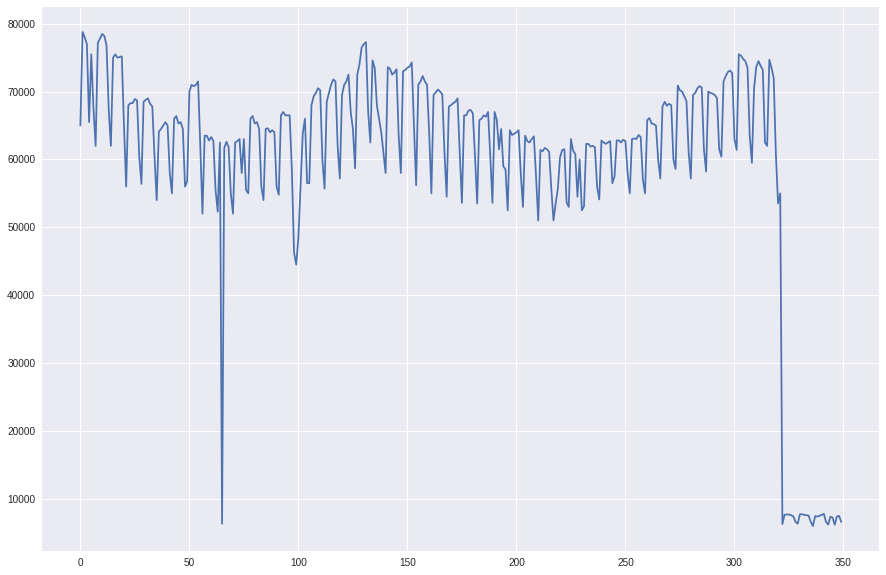

In [21]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(dataset)
plt.show()

In [22]:
# 최대 최소 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [23]:
# 훈련데이터와 테스트 데이터 분리
# 관측치의 0.67%를 훈련데이터로, 나머지를 테스트 데이터로 활용
# 주의할점 : 시계열 데이터는 값의 순서가 중요하므로 임의 샘플링(random sampling)을 통한
# 데이터 분리는 피해야 한다

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

234 116


In [24]:
# 배열을 dataset matrix 형태로 바꾼다.
# X는 주어진 시간 (t)에 승객의 수이고 Y가 다음 시간 (t + 1)에 승객의 수인 데이터 세트를 생성
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [26]:
#회귀분석
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(trainX, trainY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
# make predictions
trainPredict_lm = lm.predict(trainX)
testPredict_lm = lm.predict(testX)

In [28]:
# invert predictions
trainPredict_lm = scaler.inverse_transform(trainPredict_lm.reshape(-1, 1))
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict_lm = scaler.inverse_transform(testPredict_lm.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

In [29]:
# RME(root mean squared error) 계산
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict_lm))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict_lm))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6903.73 RMSE
Test Score: 15594.11 RMSE


In [30]:
# 그래프를 그리기 위해 train data 예측값과 test data 예측값을 합친다
totalPredict_lm = np.append(trainPredict_lm, testPredict_lm)

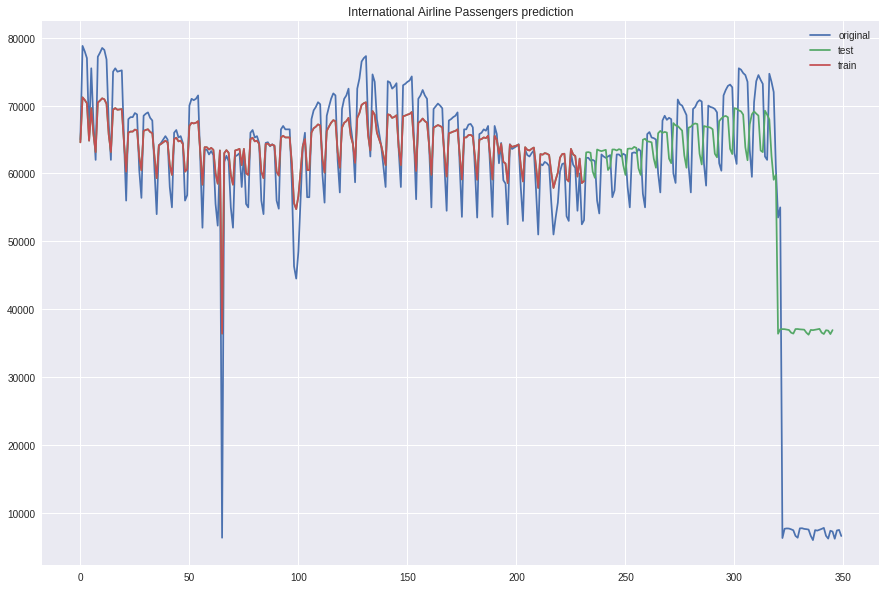

In [31]:
plt.clf()
plt.figure(figsize=(15, 10))
# plot baseline and predictions
plt.title('International Airline Passengers prediction')
plt.plot(scaler.inverse_transform(dataset), label='original')
plt.plot(totalPredict_lm, label='test')
plt.plot(trainPredict_lm, label='train')
plt.legend()
plt.show()